In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from importlib import import_module
from time import time

from stochnet_v2.dataset.simulation_gillespy import build_simulation_dataset
from stochnet_v2.dataset.dataset import DataTransformer, HDF5Dataset
from stochnet_v2.static_classes.model import StochNet
from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy, Trainer
from stochnet_v2.utils.file_organisation import ProjectFileExplorer
from stochnet_v2.utils.util import generate_gillespy_traces, plot_random_traces
from stochnet_v2.utils.util import merge_species_and_param_settings

np.set_printoptions(suppress=True, precision=2, linewidth=120)
%load_ext autoreload
%autoreload 2

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Ivan\\Documents\\StochNetV2\\project\\logger.log'

In [29]:
dataset = np.load(r'C:\Users\Ivan\Documents\StochNetV2\projectX16\dataset\data\20.0\2\dataset.npy')
histogram_dataset = np.load(r'C:\Users\Ivan\Documents\StochNetV2\projectX16\dataset\data\20.0\2\histogram_dataset.npy')

In [33]:
d = dataset.reshape(1, 150, 8)
d.shape

(1, 150, 8)

In [65]:
model_name = 'SIR'
timestep = 0.5
endtime = 10
dataset_id = 1
model_id = 1
nb_features = 3
params_to_randomize = ['beta', 'gamma']

In [37]:
model_name = 'X16'
timestep = 20.0
endtime = 200.0
dataset_id = 2
model_id = 1001
nb_features = 3
params_to_randomize = ['a11', 'a12', 'a21', 'b1']

In [3]:
model_name = 'X44'
timestep = 50.0
endtime = 500.0
dataset_id = 3
model_id = 3001
nb_features = 7
params_to_randomize = ['a11', 'b1', 'gamma12']

In [66]:
# project_folder = '/home/dn/DATA/PARAMETERIZED/' + model_name
project_folder = r'C:\Users\Ivan\Documents\StochNetV2\project' + model_name
project_explorer = ProjectFileExplorer(project_folder)
dataset_explorer = project_explorer.get_dataset_file_explorer(timestep, dataset_id)
model_explorer = project_explorer.get_model_file_explorer(timestep, model_id)

body_config_path = model_explorer.body_config_fp
mixture_config_path = model_explorer.mixture_config_fp

In [67]:
CRN_module = import_module("stochnet_v2.CRN_models." + model_name)
CRN_class = getattr(CRN_module, model_name)

## Generate traces

In [68]:
nb_settings = 15
nb_trajectories = 10

nb_histogram_settings = 10
nb_histogram_trajectories = 20


settings = CRN_class.get_initial_settings(nb_settings)
print(f"settings shape: {settings.shape}")
print(f"Saving settings to {dataset_explorer.settings_fp}")
np.save(dataset_explorer.settings_fp, settings)

dataset = build_simulation_dataset(
    model_name,
    nb_settings,
    nb_trajectories,
    timestep,
    endtime,
    dataset_explorer.dataset_folder,
    params_to_randomize=params_to_randomize,
    how='concat'
)
print(f"Saving dataset to {dataset_explorer.dataset_fp}")
np.save(dataset_explorer.dataset_fp, dataset)


histogram_settings = CRN_class.get_initial_settings(nb_histogram_settings)
print(f"histogram_settings shape: {histogram_settings.shape}")
print(f"Saving histogram_settings to {dataset_explorer.histogram_settings_fp}")
np.save(dataset_explorer.histogram_settings_fp, histogram_settings)

histogram_dataset = build_simulation_dataset(
    model_name,
    nb_histogram_settings,
    nb_histogram_trajectories,
    timestep,
    endtime,
    dataset_explorer.dataset_folder,
    params_to_randomize=params_to_randomize,
    prefix='histogram_partial_',
    how='stack',
    settings_filename=os.path.basename(dataset_explorer.histogram_settings_fp),
)
print(f"Saving histogram_dataset to {dataset_explorer.histogram_dataset_fp}")
np.save(dataset_explorer.histogram_dataset_fp, histogram_dataset)

settings shape: (15, 3)
Saving settings to C:\Users\Ivan\Documents\StochNetV2\projectSIR\dataset/data\0.5\1\settings.npy


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 197.89it/s]


Saving dataset to C:\Users\Ivan\Documents\StochNetV2\projectSIR\dataset/data\0.5\1\dataset.npy
histogram_settings shape: (10, 3)
Saving histogram_settings to C:\Users\Ivan\Documents\StochNetV2\projectSIR\dataset/data\0.5\1\histogram_settings.npy


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 238.57it/s]

Saving histogram_dataset to C:\Users\Ivan\Documents\StochNetV2\projectSIR\dataset/data\0.5\1\histogram_dataset.npy


In [69]:
histogram_dataset = np.load(dataset_explorer.histogram_dataset_fp)
histogram_dataset.shape

(10, 20, 6)

In [70]:
dataset = np.load(dataset_explorer.dataset_fp)
dataset.shape

(150, 6)

#### Plot traces

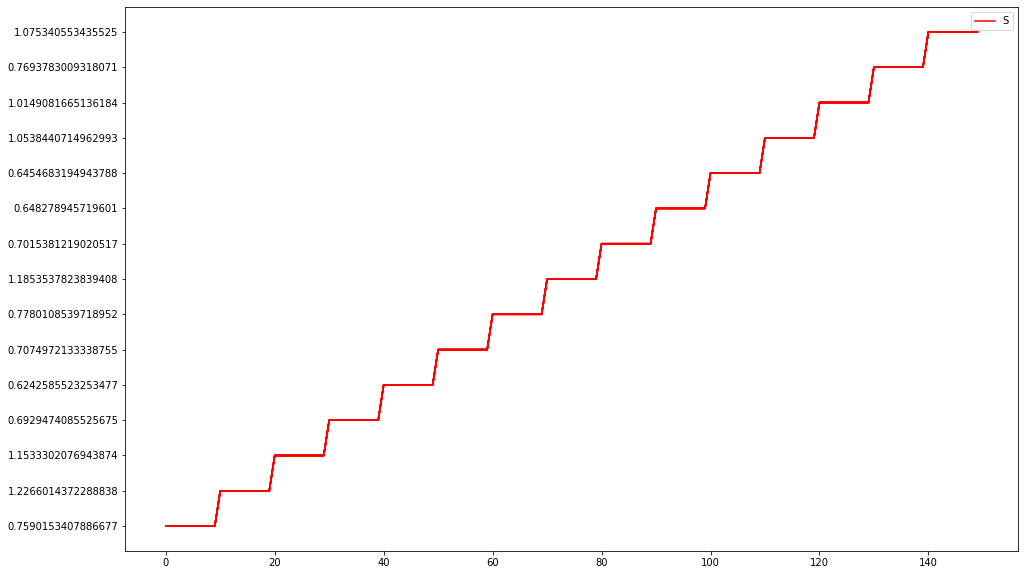

In [80]:
n = 10

plt.figure(figsize=(16, 10))
plot_random_traces(dataset, 1, labels=CRN_class.get_species_names() + params_to_randomize)
plt.legend()
plot_random_traces(dataset, n - 1, labels=CRN_class.get_species_names() + params_to_randomize)

In [28]:
setting_idx = 0
n = 10

plt.figure(figsize=(16, 10))
plot_random_traces(histogram_dataset[setting_idx], 1, labels=CRN_class.get_species_names() + params_to_randomize)
plt.legend()
plot_random_traces(histogram_dataset[setting_idx], n - 1, labels=CRN_class.get_species_names() + params_to_randomize)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1152x720 with 0 Axes>

## Transform Dataset

In [41]:
dt = DataTransformer(
    dataset_explorer.dataset_fp,
    with_timestamps=True,
    nb_randomized_params=len(params_to_randomize)
)

ValueError: could not convert string to float: 'time'

In [13]:
np.random.seed(11)

dt.save_data_for_ml_hdf5(
    dataset_folder=dataset_explorer.dataset_folder,
    nb_past_timesteps=1,
    test_fraction=0.2,
    keep_timestamps=False,
    rescale=True,
    positivity=False,
    shuffle=True,
    slice_size=100,
    force_rewrite=True
)

NameError: name 'dt' is not defined

#### Check training data

In [ ]:
import h5py

data_file = h5py.File(dataset_explorer.train_rescaled_fp, 'r')

x_data = data_file['x']
y_data = data_file['y']

i = 200

dt.scale_back(x_data[i]), dt.scale_back(y_data[i])

#### Check dataset iterator

In [ ]:
ds = HDF5Dataset(dataset_explorer.train_rescaled_fp, 64)

In [ ]:
c = 0

for x, y in ds:
    print(f'{x.shape}, {y.shape}')
    c += 1
    if c > 10:
        break
    else:
        continue
    break

## Model

#### Configure model

In [ ]:
body_hidden_size = 30
body_n_blocks = 2
body_activation = "relu"
body_regularizer = "none"
body_kernel_constraint = "none"
body_bias_constraint = "none"
body_kernel_regularizer = "l2"
body_bias_regularizer = "l2"


components_hidden_size = "none"
n_normal_diag = 6
n_normal_tril = 0
n_log_normal_tril = 0
components_activation = "none"
components_regularizer = "none"
components_kernel_constraint = "none"
components_bias_constraint = "none"
components_kernel_regularizer = "l2"
components_bias_regularizer = "l2"


body_config = {
    "body_fn_name": "body_b",
    "block_name": "a",
    "hidden_size": body_hidden_size,
    "n_blocks": body_n_blocks,
    "use_batch_norm": False,
    "activation": body_activation,
    "activity_regularizer": body_regularizer,
    "kernel_constraint": body_kernel_constraint,
    "kernel_regularizer": body_kernel_regularizer,
    "bias_constraint": body_bias_constraint,
    "bias_regularizer": body_bias_regularizer
}

categorical_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "coeff_regularizer": "none",
    "kernel_constraint": components_kernel_constraint,  # "maxnorm"
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,  # "maxnorm"
    "bias_regularizer": components_bias_regularizer
}

normal_diag_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": "l2",
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

log_normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

#### Write config files

In [ ]:
mixture_config = \
[["categorical", categorical_config]] + \
[["normal_diag", normal_diag_config] for i in range(n_normal_diag)] + \
[["normal_tril", normal_tril_config] for i in range(n_normal_tril)] + \
[["log_normal_tril", log_normal_tril_config] for i in range(n_log_normal_tril)]

with open(body_config_path, 'w+') as f:
    json.dump(body_config, f, indent='\t')

with open(mixture_config_path, 'w+') as f:
    json.dump(mixture_config, f, indent='\t')

## Configure training strategy

In [ ]:
learning_strategy = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=7,
    minimal_lr=1e-7,
)

n_epochs = 60
batch_size = 256
add_noise = True
stddev = 0.01
dataset_kind = 'hdf5'

## Initialize model

In [ ]:
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
)

## Train model

In [ ]:
ckpt_path = None

ckpt_path = Trainer().train(
    nn,
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_strategy=learning_strategy,
    ckpt_path=ckpt_path,
    dataset_kind=dataset_kind,
    add_noise=add_noise,
    stddev=stddev,
)

ckpt_path

## Evaluate

In [ ]:
from stochnet_v2.utils.evaluation import evaluate
from stochnet_v2.utils.util import plot_random_traces

In [ ]:
distance_kind = 'dist'
target_species_names = ['S', 'I']
time_lag_range = [1, 3, 5, 10, 15, 20]
settings_idxs_to_save_histograms = [i for i in range(10)]

In [ ]:
histogram_explorer = dataset_explorer.get_histogram_file_explorer(model_id, 0)
nn_histogram_data_fp = os.path.join(histogram_explorer.model_histogram_folder, 'nn_histogram_data.npy')

evaluate(
    model_name=model_name,
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    nb_randomized_params=len(params_to_randomize),
    nb_past_timesteps=1,
    n_bins=100,
    distance_kind=distance_kind,
    with_timestamps=True,
    save_histograms=True,
    time_lag_range=time_lag_range,
    target_species_names=target_species_names,
    path_to_save_nn_traces=nn_histogram_data_fp,
    settings_idxs_to_save_histograms=settings_idxs_to_save_histograms,
)

## Load trained model

In [ ]:
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    mode='inference'
)

In [ ]:
n_settings = 10
traj_per_setting = 50
n_steps = 50

m = CRN_class(endtime, timestep)

initial_settings = m.get_initial_settings(n_settings)
randomized_params = m.get_randomized_parameters(params_to_randomize, n_settings)

settings = merge_species_and_param_settings(initial_settings, randomized_params)
settings

#### Sample next state

In [ ]:
setting_idx = 0

curr_state = settings[setting_idx:setting_idx+1, np.newaxis, :]
curr_state

In [ ]:
next_state_samples = nn.next_state(
    curr_state_values=curr_state,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=False,
    n_samples=10000,
)

# [n_samples, n_settings, 1, n_features]
next_state_samples.shape

#### next state histogram

In [ ]:
species_idx = 2

samples = np.squeeze(next_state_samples, -2)[..., species_idx]

_ = plt.hist(samples, bins=50)

### Run simulatins for original and abstract models 

In [ ]:
start = time()

gillespy_traces = generate_gillespy_traces(
    settings=settings,
    n_steps=n_steps,
    timestep=timestep,
    gillespy_model=m,
    params_to_randomize=params_to_randomize,
    traj_per_setting=traj_per_setting,
)

gillespy_time = time() - start

gillespy_traces.shape, gillespy_time

In [ ]:
start = time()

nn_traces = nn.generate_traces(
    settings[:, np.newaxis, :],
    n_steps=n_steps,
    n_traces=traj_per_setting,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=True,
    add_timestamps=True,
)

nn_time = time() - start

nn_traces.shape, nn_time

### Plot traces

In [ ]:
k = 1
n_traces = 5

plt.figure(figsize=(16, 10))
plot_random_traces(gillespy_traces[k][...,:nb_features+1], n_traces, linestyle='--', marker='')
plot_random_traces(nn_traces[k], n_traces, linestyle='-', marker='')